# Audio Classification: Speaker & Language

This notebook does the following:
1. Use a single **metadata CSV** to label both **speaker** and **language**.
2. Extract **MFCC features** from each audio file.
3. Perform **binary classification** separately for:
   - **Speaker** (Jeevan vs. Not_Jeevan)
   - **Language** (English vs. Not_English)
4. Use **k-Fold Cross-Validation** to evaluate performance (accuracy, precision, recall, F1) and generate confusion matrices.

In [24]:
#Importing ALl libraries
import os
import pandas as pd
import librosa
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix,
                             classification_report, precision_score, recall_score,
                             f1_score, auc)
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# Data Collection
__ Add Text Here

* Youtube
* Google Photos
* Facebook and Messenger
* Recorded to balance Data

# Data Pre Processing
__ Add text here

And code if needed. Or link to Github
* Used yt_dlp to download just the audio from youtube videos (These videos contain just my speech). No copyright infriengement intended. The channel used is in the codecell.
* Used __ to convert all video into audio
* Used librosa, ffemg to trim audio data into equal slices of 7 seconds (source for why that's suitable), removed silence, and added empty voice when a segment would be less than 7 seconds.

## What needs to be done:
These factors might result in some inaccuracy.
* The audio is recorded from a phone, often with a lot of wind or people in the background. So, there's some noise that needs to be cleaned.
* Some data is labeled as one class but has data from both classes. 
    * In conversations when both people are speaking in one segment, I classified it based on whoever is speaking for a longer time duration. 
    * People who speak Nepali also sprinkle English words in between, again I used the majority time rule to label data.

# Data Labeling
The most challenging part after fining the data was labeling.

__ Add more__

# Data Analysis

###  Initial Distribution: 
My first phase of data was unbalanced. Not surprisingly I had more voice of myself talking than other people. The initial data looked as bwlow:

<img src = "initial_data_distribution.png">
Total Files: 561

Counts by Speaker:
  speaker_label  count
0        Jeevan    418
1    Not_Jeevan    143

Counts by Language:
  language_label  count
0    Not_English    350
1        English    211


This data would get an accuracy of 74.5% to predict Jeevan even when the model is not working. To remove this bias, I collected more data, and did the same pre-processing steps and got the following nearly symmetrical distribution.

Total Files: 823

Counts by Speaker:
  speaker_label  count
0        Jeevan    418
1    Not_Jeevan    405

Counts by Language:
  language_label  count
0    Not_English    434
1        English    389


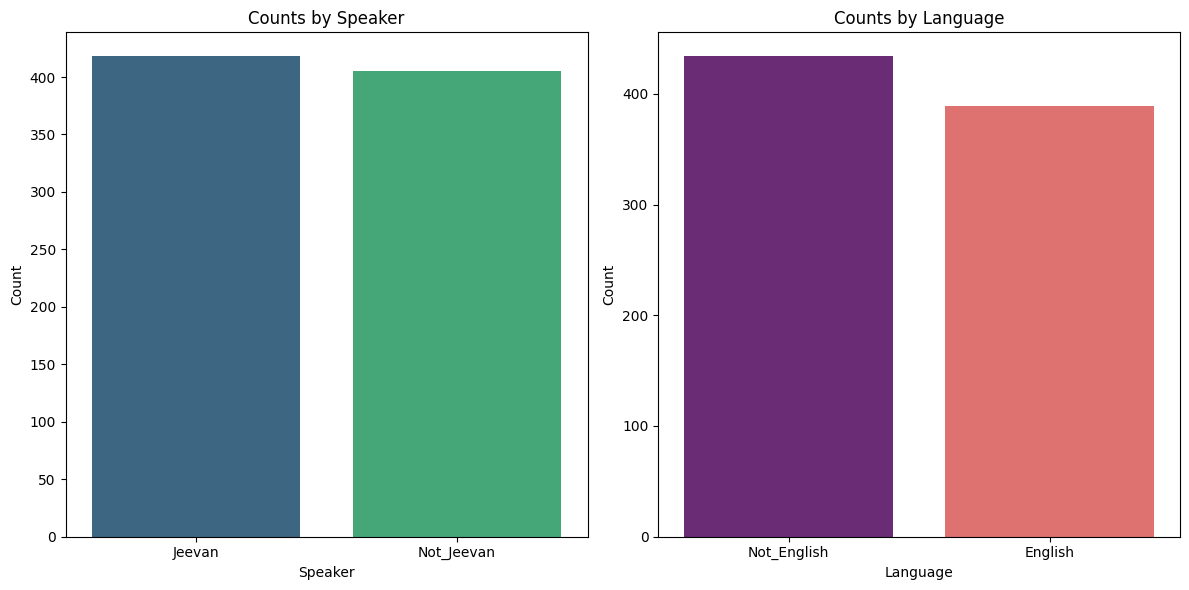

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress FutureWarnings from seaborn (or other libraries)
warnings.filterwarnings("ignore", category=FutureWarning)

# Load the CSV file, which already has a header row
df = pd.read_csv('data/metadata.csv') 

# Total data statistics
total_files = len(df)
print("Total Files:", total_files)

# Statistics by speaker
speaker_counts = df['speaker_label'].value_counts().reset_index()
speaker_counts.columns = ['speaker_label', 'count']
print("\nCounts by Speaker:")
print(speaker_counts)

# Statistics by language
language_counts = df['language_label'].value_counts().reset_index()
language_counts.columns = ['language_label', 'count']
print("\nCounts by Language:")
print(language_counts)

# Visualization: Bar plots for speaker and language counts
plt.figure(figsize=(12, 6))

# Bar plot for speaker counts
plt.subplot(1, 2, 1)
sns.barplot(data=speaker_counts, x='speaker_label', y='count', palette="viridis")
plt.title("Counts by Speaker")
plt.xlabel("Speaker")
plt.ylabel("Count")

# Bar plot for language counts
plt.subplot(1, 2, 2)
sns.barplot(data=language_counts, x='language_label', y='count', palette="magma")
plt.title("Counts by Language")
plt.xlabel("Language")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


In [3]:

def extract_features(file_path, sr=16000, n_mfcc=13):
    """
    Loads the audio file, extracts MFCC features, and returns the averaged MFCCs.
    """
    y, sr = librosa.load(file_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    return mfcc_mean

def build_dataset(metadata_csv, audio_dir):
    """
    Reads metadata from a CSV that has at least 3 columns:
        - filename
        - speaker_label (e.g., "Jeevan" or "Not_Jeevan")
        - language_label (e.g., "English" or "Not_English")
    """
    df = pd.read_csv(metadata_csv)
    X, y_speaker, y_language = [], [], []
    for _, row in df.iterrows():
        file_path = os.path.join(audio_dir, row['filename'])
        X.append(extract_features(file_path))
        y_speaker.append(1 if row['speaker_label'].lower() == 'jeevan' else 0)
        y_language.append(1 if row['language_label'].lower() == 'english' else 0)
    return np.array(X), np.array(y_speaker), np.array(y_language)

def evaluate_classifier(X, y, n_splits=5):
    """
    Performs k-Fold cross-validation, returns classification metrics and a confusion matrix.
    """
    clf = SVC(kernel='linear', probability=True, random_state=42)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    y_pred = cross_val_predict(clf, X, y, cv=skf)
    return classification_report(y, y_pred, target_names=["Class 0", "Class 1"]), confusion_matrix(y, y_pred)

# Models Used Use K-fold cross validation

In [4]:
def extract_features(file_path, sr=16000, n_mfcc=13):
    """
    Loads the audio file, extracts MFCC features, and returns the averaged MFCCs.
    """
    y, sr = librosa.load(file_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    return mfcc_mean

def build_dataset(metadata_csv, audio_dir):
    """
    Reads metadata from a CSV that has at least 3 columns:
        - filename
        - speaker_label (e.g., "Jeevan" or "Not_Jeevan")
        - language_label (e.g., "English" or "Not_English")
    
    For each row:
      - Extracts MFCC features from the audio file.
      - Creates a binary label for speaker (1 for "Jeevan", 0 for others).
      - Creates a binary label for language (1 for "English", 0 for others).
    
    Returns:
      - X: Array of MFCC feature vectors.
      - y_speaker: Array of binary labels for speaker classification.
      - y_language: Array of binary labels for language classification.
    """
    df = pd.read_csv(metadata_csv)
    X, y_speaker, y_language = [], [], []
    for _, row in df.iterrows():
        file_path = os.path.join(audio_dir, row['filename'])
        features = extract_features(file_path)
        X.append(features)
        y_speaker.append(1 if row['speaker_label'].lower() == 'jeevan' else 0)
        y_language.append(1 if row['language_label'].lower() == 'english' else 0)
    return np.array(X), np.array(y_speaker), np.array(y_language)

def evaluate_classifier(X, y, clf, n_splits=5):
    """
    Performs k-Fold cross-validation using the specified classifier.
    
    Parameters:
      - X: Feature array.
      - y: True labels.
      - clf: A classifier instance.
      - n_splits: Number of folds for cross-validation.
    
    Returns:
      - report: A classification report as a string.
      - cm: The confusion matrix as a NumPy array.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    y_pred = cross_val_predict(clf, X, y, cv=skf)
    report = classification_report(y, y_pred, target_names=["Class 0", "Class 1"])
    cm = confusion_matrix(y, y_pred)
    return report, cm

def run_multiple_classifiers(X, y, classifiers, n_splits=5):
    """
    Evaluates multiple classifiers using K-fold cross-validation.
    
    Parameters:
      - X: Features array.
      - y: Labels.
      - classifiers: Dictionary of classifiers (name: classifier instance).
      - n_splits: Number of cross-validation folds.
    
    Returns:
      - A dictionary mapping classifier names to their evaluation results (report and confusion matrix).
    """
    results = {}
    for name, clf in classifiers.items():
        print(f"Evaluating {name}...")
        report, cm = evaluate_classifier(X, y, clf, n_splits)
        results[name] = {"report": report, "confusion_matrix": cm}
    return results
def plot_confusion_matrix(cm, title):
    """
    Plots the confusion matrix using seaborn heatmap.
    """
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


### Building the dataset

In [5]:
# Evaluate classifiers for Speaker Classification

# Paths to metadata CSV and audio files folder
metadata_csv_path = "data/metadata.csv"
audio_directory = "data/audio_data"

# Build dataset
X, y_speaker, y_language = build_dataset(metadata_csv_path, audio_directory)

#Visualizing the Data
print("X shape:", X.shape)
print("y_speaker shape:", y_speaker.shape)
print("y_language shape:", y_language.shape)


X shape: (823, 13)
y_speaker shape: (823,)
y_language shape: (823,)


Hence, the audio data has 13 features that we are considering.

y_speaker.shape and y_language.shape both return (n_samples,) because there is one speaker/language label per audio file.
https://librosa.org/doc/main/feature.html#
Talk more about the feature extraction process. Maybe critique on what's helpful and what I would customize.

In [6]:
#Build Dataset and Evaluate Classifiers

# Define multiple classifiers.
# Note: Increased max_iter for LogisticRegression to reduce convergence warnings.
classifiers = {
    "SVM": SVC(kernel='linear', probability=True, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42)
}


print("### Speaker Classification Results ###")
speaker_results = run_multiple_classifiers(X, y_speaker, classifiers)

# Evaluate classifiers for Language Classification
print("\n### Language Classification Results ###")
language_results = run_multiple_classifiers(X, y_language, classifiers)


### Speaker Classification Results ###
Evaluating SVM...
Evaluating RandomForest...
Evaluating LogisticRegression...

### Language Classification Results ###
Evaluating SVM...
Evaluating RandomForest...
Evaluating LogisticRegression...


In [7]:
# Classification Reports
print("### Detailed Classification Reports for Speaker Classification ###")
for name, res in speaker_results.items():
    print(f"\nClassifier: {name}")
    print(res["report"])
    print("Confusion Matrix:")
    print(res["confusion_matrix"])
    
print("\n### Detailed Classification Reports for Language Classification ###")
for name, res in language_results.items():
    print(f"\nClassifier: {name}")
    print(res["report"])
    print("Confusion Matrix:")
    print(res["confusion_matrix"])


### Detailed Classification Reports for Speaker Classification ###

Classifier: SVM
              precision    recall  f1-score   support

     Class 0       0.86      0.86      0.86       405
     Class 1       0.86      0.86      0.86       418

    accuracy                           0.86       823
   macro avg       0.86      0.86      0.86       823
weighted avg       0.86      0.86      0.86       823

Confusion Matrix:
[[347  58]
 [ 58 360]]

Classifier: RandomForest
              precision    recall  f1-score   support

     Class 0       0.96      0.95      0.95       405
     Class 1       0.95      0.96      0.95       418

    accuracy                           0.95       823
   macro avg       0.95      0.95      0.95       823
weighted avg       0.95      0.95      0.95       823

Confusion Matrix:
[[384  21]
 [ 18 400]]

Classifier: LogisticRegression
              precision    recall  f1-score   support

     Class 0       0.84      0.84      0.84       405
     Class 1 

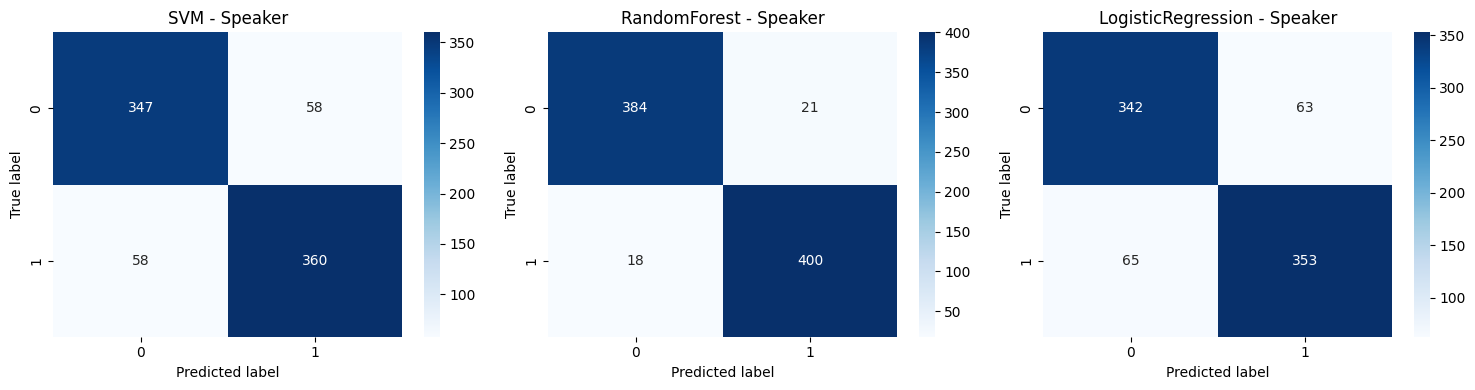

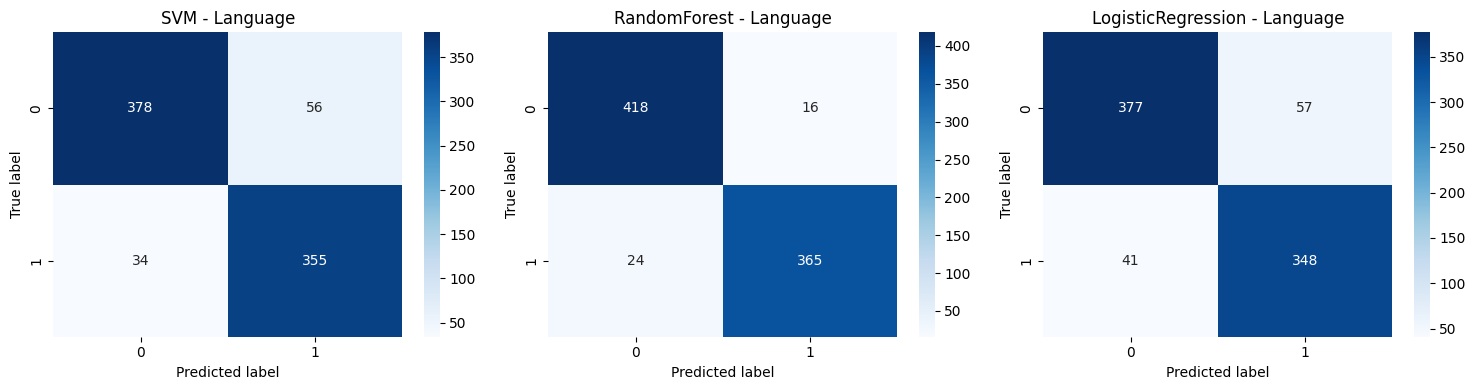

In [8]:
# Confusion Matrices for all Classification Types

def visualize_results(results, label_type):
    """
    Plots confusion matrices for each classifier.
    """
    num_classifiers = len(results)
    fig, axes = plt.subplots(1, num_classifiers, figsize=(5 * num_classifiers, 4))
    if num_classifiers == 1:
        axes = [axes]
    for ax, (name, res) in zip(axes, results.items()):
        cm = res['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title(f"{name} - {label_type}")
        ax.set_ylabel('True label')
        ax.set_xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Visualize confusion matrices for Speaker Classification
visualize_results(speaker_results, 'Speaker')

# Visualize confusion matrices for Language Classification
visualize_results(language_results, 'Language')

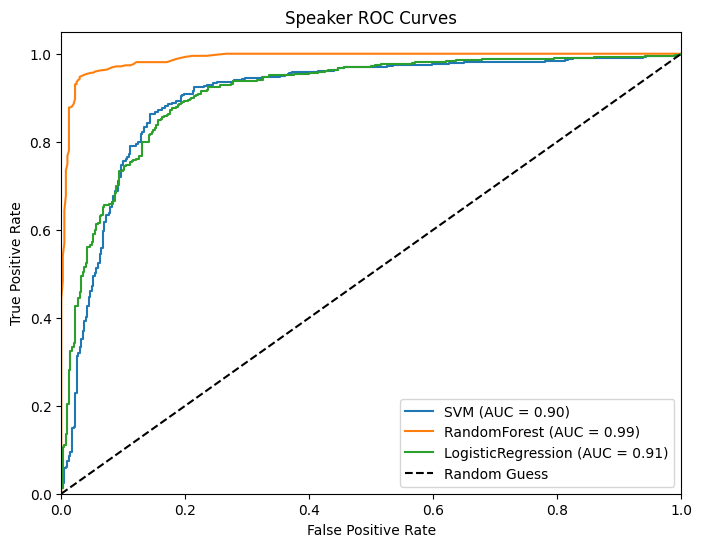

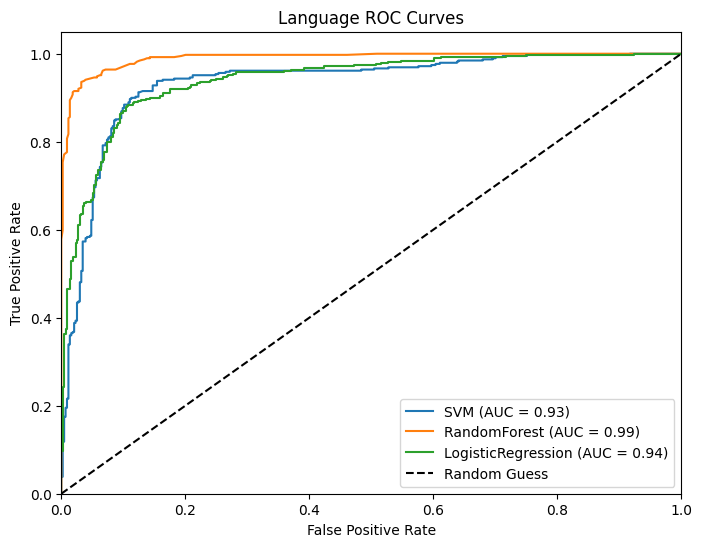

In [11]:
def plot_roc_curves(X, y, classifiers, title="ROC Curves"):
    """
    Plots the ROC curves for each classifier in 'classifiers'
    using cross-validation predictions.
    """
    plt.figure(figsize=(8, 6))
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for name, clf in classifiers.items():
        # Get predicted probabilities using cross_val_predict
        # We specify method="predict_proba" to get probability estimates
        y_proba = cross_val_predict(clf, X, y, cv=skf, method="predict_proba")[:, 1]

        # Compute FPR, TPR for the ROC curve
        fpr, tpr, _ = roc_curve(y, y_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Example usage for Speaker classification:
plot_roc_curves(X, y_speaker, classifiers, title="Speaker ROC Curves")

# Example usage for Language classification:
plot_roc_curves(X, y_language, classifiers, title="Language ROC Curves")


### Comparing different Metrics

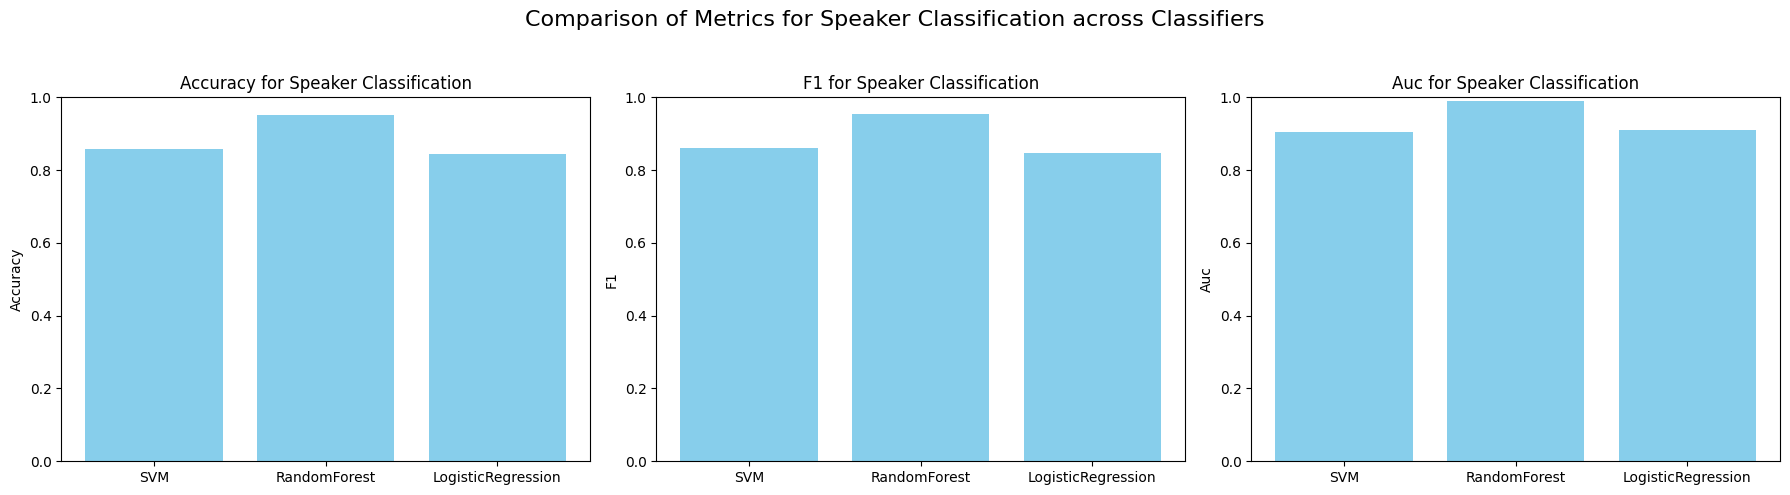

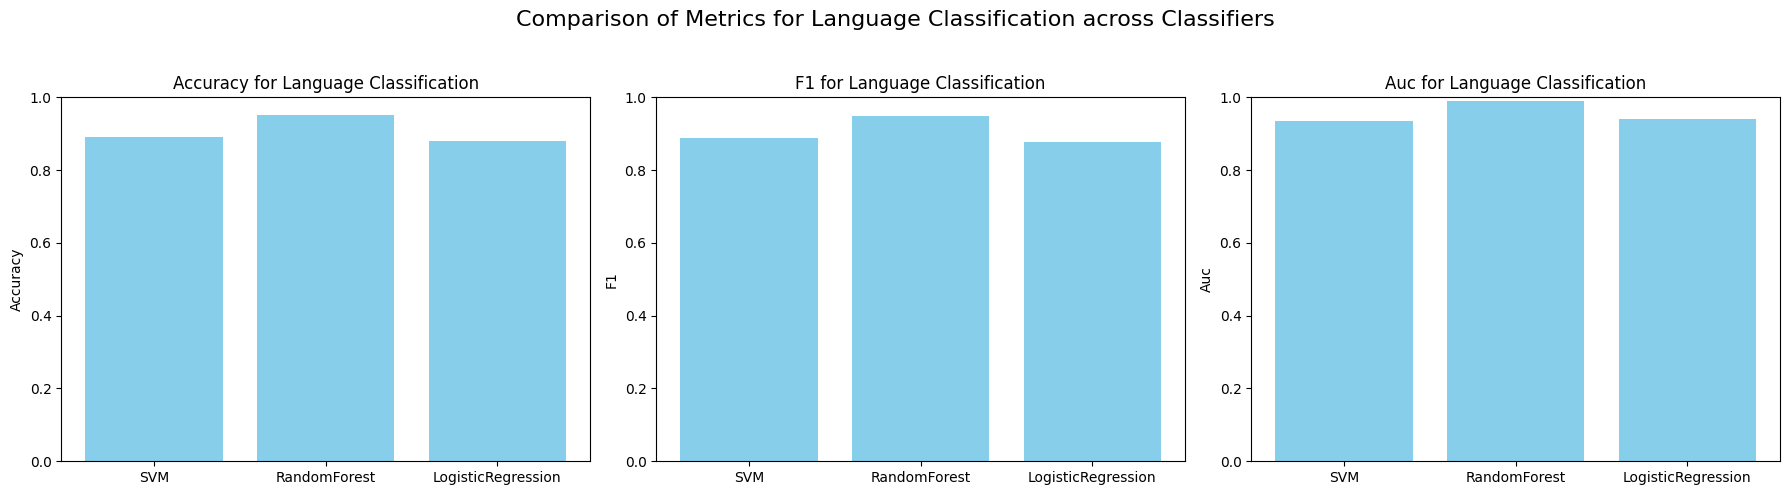

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

def compare_metrics_bar_plots(X, y, classifiers, label_type=""):
    """
    Evaluates each classifier using 5-fold cross-validation and displays side-by-side bar plots 
    for the following metrics:
      - Accuracy
      - F1 Score
      - AUC
    
    Parameters:
      X : numpy array of shape (m, n)
          Feature matrix.
      y : numpy array of shape (m,)
          Binary labels.
      classifiers : dict
          Dictionary of classifiers (name: classifier instance).
      label_type : str
          A string indicating the type of label (e.g., "Speaker" or "Language")
          for use in plot titles.
    """
    metrics_names = ['accuracy', 'f1', 'auc']
    results = {metric: {} for metric in metrics_names}
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for name, clf in classifiers.items():
        # Get predicted labels for accuracy and F1
        y_pred = cross_val_predict(clf, X, y, cv=skf)
        acc = accuracy_score(y, y_pred)
        f1_val = f1_score(y, y_pred)
        results['accuracy'][name] = acc
        results['f1'][name] = f1_val
        
        # Get predicted probabilities for AUC
        y_proba = cross_val_predict(clf, X, y, cv=skf, method="predict_proba")[:, 1]
        auc_val = roc_auc_score(y, y_proba)
        results['auc'][name] = auc_val

    # Create a figure with 3 subplots side by side
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, metric in enumerate(metrics_names):
        ax = axes[i]
        ax.bar(results[metric].keys(), results[metric].values(), color='skyblue')
        ax.set_ylim([0, 1])
        ax.set_title(f"{metric.capitalize()} for {label_type} Classification")
        ax.set_ylabel(metric.capitalize())
    fig.suptitle(f"Comparison of Metrics for {label_type} Classification across Classifiers", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

#Speaker classification:
compare_metrics_bar_plots(X, y_speaker, classifiers, label_type="Speaker")

#Language classification:
compare_metrics_bar_plots(X, y_language, classifiers, label_type="Language")

### Random Forest is doing the best across all metrics and labels.

####  Visualizing Audio Data
Because these feature vectors are high-dimensional (13 dimensions), we will reduce them to 2 dimensions for visualization. We will use Principal Component Analysis (PCA) to do so.

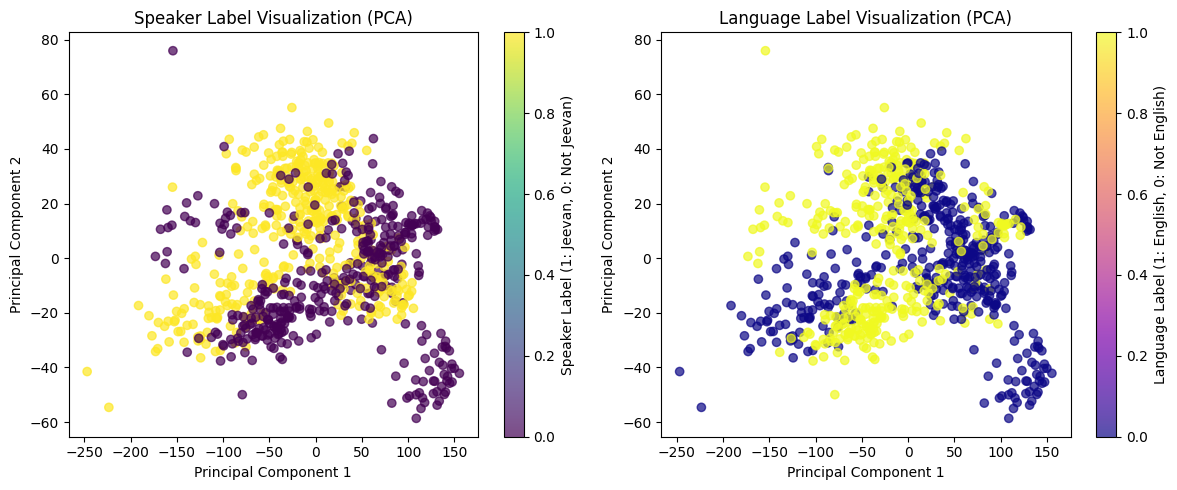

In [15]:
def plot_pca_scatter(X, y1, y2, n_components=2, comp_x=0, comp_y=1, figsize=(12, 5),
                     title1="Speaker Label Visualization (PCA)",
                     title2="Language Label Visualization (PCA)",
                     label1="Speaker Label (1: Jeevan, 0: Not Jeevan)",
                     label2="Language Label (1: English, 0: Not English)",
                     cmap1='viridis', cmap2='plasma', alpha=0.7):
    """
    Reduces the features in X using PCA and creates two scatter plots:
    - The first plot visualizes the data points colored by y1.
    - The second plot visualizes the data points colored by y2.
    
    Parameters:
      X : numpy array of shape [n_samples, n_features]
      y1 : numpy array (first set of labels)
      y2 : numpy array (second set of labels)
      n_components : int, default=2, the number of PCA components to compute
      comp_x : int, default=0, index of the PCA component to plot on the x-axis
      comp_y : int, default=1, index of the PCA component to plot on the y-axis
      ... (other parameters as before)
    """
    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X)
    
    plt.figure(figsize=figsize)
    
    plt.subplot(1, 2, 1)
    scatter1 = plt.scatter(X_reduced[:, comp_x], X_reduced[:, comp_y], c=y1, cmap=cmap1, alpha=alpha)
    plt.xlabel(f"Principal Component {comp_x+1}")
    plt.ylabel(f"Principal Component {comp_y+1}")
    plt.title(title1)
    plt.colorbar(scatter1, label=label1)
    
    plt.subplot(1, 2, 2)
    scatter2 = plt.scatter(X_reduced[:, comp_x], X_reduced[:, comp_y], c=y2, cmap=cmap2, alpha=alpha)
    plt.xlabel(f"Principal Component {comp_x+1}")
    plt.ylabel(f"Principal Component {comp_y+1}")
    plt.title(title2)
    plt.colorbar(scatter2, label=label2)
    
    plt.tight_layout()
    plt.show()

#Choose the number of components and the two components to plot here.
plot_pca_scatter(X, y_speaker, y_language, n_components=3, comp_x=0, comp_y=1)

## Training a Model without Library (Logistic Regression)

### Mathematical Explanation of Logistic Regression for Audio Classification

In this example, we train a logistic regression model from scratch to classify audio data (e.g., determining whether the speaker is "Jeevan" or not). Each audio file is represented by a feature vector of 13 dimensions—these dimensions come from averaging 13 Mel Frequency Cepstral Coefficients (MFCCs) extracted from the audio.

---

#### 1. The Logistic Regression Model

**Model Formulation:**

For each audio sample, the logistic regression model computes a linear combination of the features and passes it through a sigmoid function. Mathematically, for an input feature vector  \( x \in \mathbb{R}^{13} \), we compute:

$$
z = w^T x + b = \sum_{j=1}^{13} w_j x_j + b,
$$

where:
- \( w \in \mathbb{R}^{13} \) is the weight vector,
- \( b \) is the bias term.

The sigmoid function \( \sigma(z) \) then converts the linear combination \( z \) into a probability:

$$
\hat{y} = \sigma(z) = \frac{1}{1 + e^{-z}}.
$$

**Interpretation:**
- \( \hat{y} \) represents the probability that the given audio sample belongs to the positive class (e.g., "Jeevan").
- If \( \hat{y} > 0.5 \), we classify the audio as class 1; otherwise, it is classified as class 0.

---

#### 2. The Cost Function

To train our model, we need to measure how well it predicts the correct labels. We use the **binary cross-entropy loss** (also known as the log loss) defined as:

$$
J(w, b) = -\frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log\left(\hat{y}^{(i)}\right) + \left(1 - y^{(i)}\right) \log\left(1 - \hat{y}^{(i)}\right) \right],
$$

where:
- \( m \) is the number of training examples,
- \( y^{(i)} \) is the true label for the \( i \)-th example,
- \( \hat{y}^{(i)} \) is the predicted probability for the \( i \)-th example.

**Usage in Our Case:**
- The cost function quantifies the error between the predicted probabilities and the actual labels for all audio samples.
- Our goal is to minimize \( J(w, b) \) by adjusting the weights \( w \) and bias \( b \).

---

#### 3. Gradient Descent Updates

We minimize the cost function using gradient descent. The gradients of the cost with respect to the weights and bias are given by:

$$
\frac{\partial J}{\partial w} = \frac{1}{m} X^T (\hat{y} - y),
$$

$$
\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} \left(\hat{y}^{(i)} - y^{(i)}\right),
$$

where:
- \( X \) is the matrix of all feature vectors,
- \( \hat{y} \) is the vector of predicted probabilities,
- \( y \) is the vector of true labels.

Then, the parameters are updated as follows:

$$
w := w - \alpha \frac{\partial J}{\partial w}, \quad b := b - \alpha \frac{\partial J}{\partial b},
$$

where \( \alpha \) is the learning rate.

**How It Is Used:**
- At each iteration of training, the model calculates the gradients using the current weights and bias.
- It then updates the parameters to reduce the cost, iteratively improving the model’s predictions.

---

#### 4. Classification of Audio Data

After training, classification of a new audio sample proceeds as follows:

1. **Feature Extraction:**  
   Each audio file is processed to extract 13 averaged MFCC values, resulting in a 13-dimensional feature vector \( x \).

2. **Linear Combination:**  
   The model computes:
   
   $$
   z = \sum_{j=1}^{13} w_j x_j + b.
   $$

3. **Probability Calculation:**  
   The sigmoid function converts \( z \) into a probability:
   
   $$
   \hat{y} = \frac{1}{1 + e^{-z}}.
   $$

4. **Decision Rule:**  
   The sample is classified as class 1 (e.g., "Jeevan") if \( \hat{y} > 0.5 \) and class 0 otherwise.

**Summary:**  
- We transform each audio file into a 13-dimensional feature vector using MFCC averaging.
- The logistic regression model uses these 13 features to compute a score and then converts it into a probability.
- Based on this probability, the audio sample is classified into one of two classes.

This framework allows us to directly relate the audio data (with 13 dimensions) to the classification decision through a simple, interpretable mathematical model.


In [13]:
def sigmoid(z):
    """Compute the sigmoid function."""
    return 1 / (1 + np.exp(-z))

def train_logistic_regression(X, y, learning_rate=0.01, num_iterations=1000):
    """
    Trains a logistic regression model from scratch using gradient descent.
    
    Parameters:
        X : numpy array of shape (m, n)
            Feature matrix, where m is the number of samples and n is the number of features.
        y : numpy array of shape (m,)
            Binary labels (0 or 1) for each sample.
        learning_rate : float
            The step size for gradient descent.
        num_iterations : int
            Number of iterations for gradient descent.
            
    Returns:
        w : numpy array of shape (n, 1)
            Learned weights.
        b : float
            Learned bias.
    """
    m, n = X.shape
    w = np.zeros((n, 1))  # Initialize weights
    b = 0                 # Initialize bias
    
    # Reshape y to a column vector
    y = y.reshape(m, 1)
    
    for i in range(num_iterations):
        # Forward pass
        Z = np.dot(X, w) + b    # shape: (m, 1)
        A = sigmoid(Z)          # shape: (m, 1)
        
        # Compute binary cross-entropy loss
        cost = -(1/m) * np.sum(y * np.log(A + 1e-15) + (1 - y) * np.log(1 - A + 1e-15))
        
        # Backprop: compute gradients
        dW = (1/m) * np.dot(X.T, (A - y))  # shape: (n, 1)
        dB = (1/m) * np.sum(A - y)
        
        # Parameter update
        w -= learning_rate * dW
        b -= learning_rate * dB
        
        if i % 100 == 0:
            print(f"Iteration {i}, Cost: {cost:.4f}")
    
    return w, b

def predict_logistic_regression(X, w, b, threshold=0.5):
    """
    Predicts binary labels using the trained logistic regression model.
    """
    Z = np.dot(X, w) + b
    A = sigmoid(Z)
    return (A > threshold).astype(int).flatten()

def predict_proba_logistic_regression(X, w, b):
    """
    Returns predicted probabilities for the positive class.
    """
    Z = np.dot(X, w) + b
    return sigmoid(Z).flatten()

Iteration 0, Cost: 0.6931
Iteration 100, Cost: 0.4985
Iteration 200, Cost: 0.4637
Iteration 300, Cost: 0.4451
Iteration 400, Cost: 0.4329
Iteration 500, Cost: 0.4243
Iteration 600, Cost: 0.4177
Iteration 700, Cost: 0.4125
Iteration 800, Cost: 0.4083
Iteration 900, Cost: 0.4049
Iteration 1000, Cost: 0.4020
Iteration 1100, Cost: 0.3995
Iteration 1200, Cost: 0.3973
Iteration 1300, Cost: 0.3955
Iteration 1400, Cost: 0.3938
Iteration 1500, Cost: 0.3924
Iteration 1600, Cost: 0.3911
Iteration 1700, Cost: 0.3900
Iteration 1800, Cost: 0.3890
Iteration 1900, Cost: 0.3881
Iteration 2000, Cost: 0.3872
Iteration 2100, Cost: 0.3865
Iteration 2200, Cost: 0.3858
Iteration 2300, Cost: 0.3852
Iteration 2400, Cost: 0.3847
Iteration 2500, Cost: 0.3842
Iteration 2600, Cost: 0.3837
Iteration 2700, Cost: 0.3833
Iteration 2800, Cost: 0.3829
Iteration 2900, Cost: 0.3826
Iteration 3000, Cost: 0.3823
Iteration 3100, Cost: 0.3820
Iteration 3200, Cost: 0.3817
Iteration 3300, Cost: 0.3815
Iteration 3400, Cost: 0.38

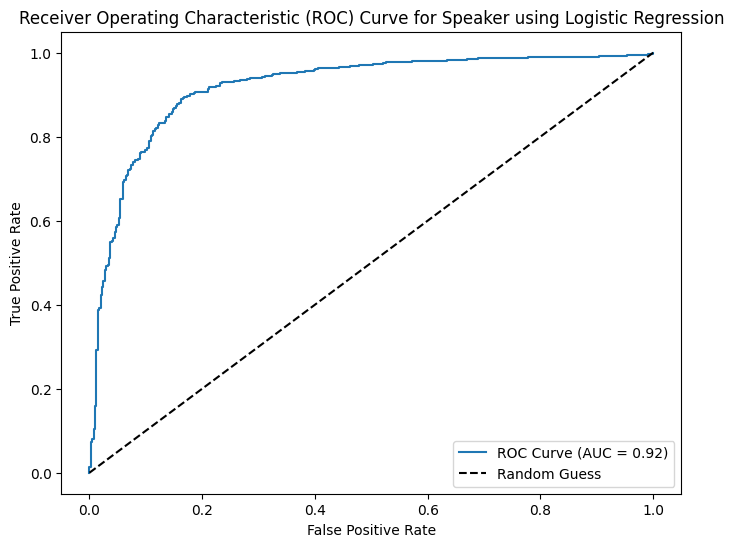

In [23]:
# Speaker Classification using Logistic Regression
# 1. Train logistic regression from scratch
learning_rate = 0.001
num_iterations = 10000
w, b = train_logistic_regression(X, y_speaker, learning_rate, num_iterations)

# 2. Compute binary predictions (for confusion matrix, accuracy, etc.)
predictions = predict_logistic_regression(X, w, b, threshold=0.5)

accuracy = np.mean(predictions == y_speaker) * 100
print(f"\nTraining Accuracy: {accuracy:.2f}%")

print("\nClassification Report:")
print(classification_report(y_speaker, predictions))

conf_mat = confusion_matrix(y_speaker, predictions)
print("Confusion Matrix:")
print(conf_mat)

precision = precision_score(y_speaker, predictions)
recall = recall_score(y_speaker, predictions)
f1 = f1_score(y_speaker, predictions)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# 3. Get continuous probabilities for ROC/AUC
probabilities = predict_proba_logistic_regression(X, w, b)

auc_score = roc_auc_score(y_speaker, probabilities)
print(f"AUC: {auc_score:.2f}")

# 4. Plot the ROC curve
fpr, tpr, _ = roc_curve(y_speaker, probabilities)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve for Speaker using Logistic Regression")
plt.legend(loc="lower right")
plt.show()


Iteration 0, Cost: 0.6931
Iteration 100, Cost: 0.3789
Iteration 200, Cost: 0.3564
Iteration 300, Cost: 0.3454
Iteration 400, Cost: 0.3381
Iteration 500, Cost: 0.3329
Iteration 600, Cost: 0.3287
Iteration 700, Cost: 0.3254
Iteration 800, Cost: 0.3226
Iteration 900, Cost: 0.3203
Iteration 1000, Cost: 0.3183
Iteration 1100, Cost: 0.3165
Iteration 1200, Cost: 0.3150
Iteration 1300, Cost: 0.3137
Iteration 1400, Cost: 0.3125
Iteration 1500, Cost: 0.3114
Iteration 1600, Cost: 0.3104
Iteration 1700, Cost: 0.3095
Iteration 1800, Cost: 0.3087
Iteration 1900, Cost: 0.3080
Iteration 2000, Cost: 0.3074
Iteration 2100, Cost: 0.3067
Iteration 2200, Cost: 0.3062
Iteration 2300, Cost: 0.3057
Iteration 2400, Cost: 0.3052
Iteration 2500, Cost: 0.3047
Iteration 2600, Cost: 0.3043
Iteration 2700, Cost: 0.3039
Iteration 2800, Cost: 0.3036
Iteration 2900, Cost: 0.3032
Iteration 3000, Cost: 0.3029
Iteration 3100, Cost: 0.3026
Iteration 3200, Cost: 0.3024
Iteration 3300, Cost: 0.3021
Iteration 3400, Cost: 0.30

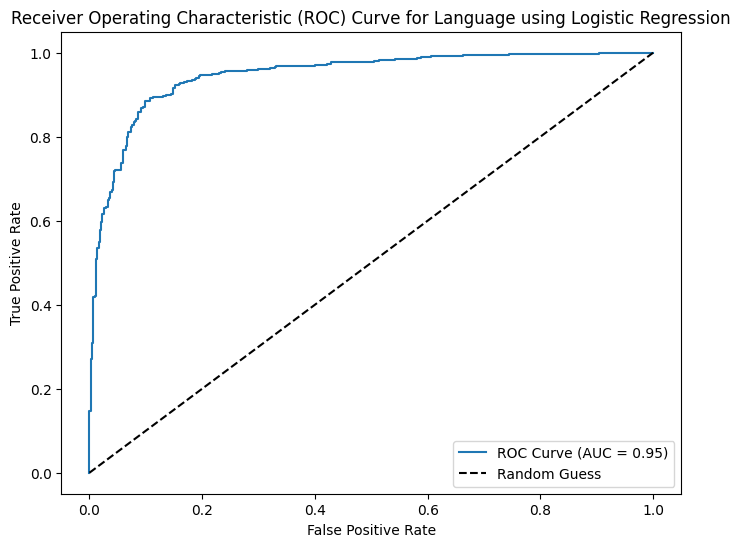

In [22]:
# Classifying for Language Label

# 1. Train logistic regression from scratch
learning_rate = 0.001 # I brute-forced learning rate and this seems to qork quite well for this classification. It's not the best though.
num_iterations = 10000
w, b = train_logistic_regression(X, y_language, learning_rate, num_iterations)

# 2. Compute binary predictions (for confusion matrix, accuracy, etc.)
predictions = predict_logistic_regression(X, w, b, threshold=0.5)

accuracy = np.mean(predictions == y_language) * 100
print(f"\nTraining Accuracy: {accuracy:.2f}%")

print("\nClassification Report:")
print(classification_report(y_language, predictions))

conf_mat = confusion_matrix(y_language, predictions)
print("Confusion Matrix:")
print(conf_mat)

precision = precision_score(y_language, predictions)
recall = recall_score(y_language, predictions)
f1 = f1_score(y_language, predictions)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# 3. Get continuous probabilities for ROC/AUC
probabilities = predict_proba_logistic_regression(X, w, b)

auc_score = roc_auc_score(y_language, probabilities)
print(f"AUC: {auc_score:.2f}")

# 4. Plot the ROC curve
fpr, tpr, _ = roc_curve(y_language, probabilities)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve for Language using Logistic Regression")
plt.legend(loc="lower right")
plt.show()


## Plotting Decision boundary 
#### Using PCA and two components for ease of visualization

In [30]:
def plot_pca_decision_boundary(X, y, w, b, n_components=2, comp_x=0, comp_y=1, 
                               figsize=(8, 6), label_type="Language (1=English, 0=Not English)",
                               title="Decision Boundary (PCA)"):
    """
    Uses PCA to reduce the features in X to 2 dimensions, plots the data points colored by y, and overlays
    the decision boundary of the logistic regression model trained on the original X.
    
    Parameters:
      X : numpy array of shape (m, n)
          Original feature matrix.
      y : numpy array of shape (m,)
          Binary labels (0 or 1).
      w : numpy array of shape (n, 1)
          Logistic regression weights (trained on X).
      b : float
          Logistic regression bias.
      n_components : int, default=2
          Number of PCA components.
      comp_x, comp_y : int, default=0,1
          Indices of the PCA components to plot on the x- and y-axes.
      figsize : tuple, default=(8,6)
          Figure size.
      label_type : str
          Descriptive label for the color bar (e.g. "Language (1=English, 0=Not English)").
      title : str
          Title for the plot.
    """
    # Fit PCA on the original features X
    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X)
    
    plt.figure(figsize=figsize)
    # Plot the data points in the reduced space, colored by y
    scatter = plt.scatter(X_reduced[:, comp_x], X_reduced[:, comp_y], c=y, cmap='viridis', alpha=0.7)
    plt.xlabel(f"Principal Component {comp_x+1}")
    plt.ylabel(f"Principal Component {comp_y+1}")
    plt.title(title)
    cbar = plt.colorbar(scatter)
    cbar.set_label(label_type)  # More descriptive color bar label
    
    # Compute the effective weights in PCA space
    w_reduced = pca.components_.dot(w)  # shape: (n_components, 1)
    
    # Generate a range of values for the x-axis (first principal component)
    x_min, x_max = X_reduced[:, comp_x].min(), X_reduced[:, comp_x].max()
    x_vals = np.linspace(x_min, x_max, 200)
    
    # Solve for y-axis in PCA space: w_reduced[0]*z0 + w_reduced[1]*z1 + b = 0
    # => z1 = -(w_reduced[0]*z0 + b) / w_reduced[1]
    y_vals = -(w_reduced[comp_x]*x_vals + b) / w_reduced[comp_y]
    
    # Plot the decision boundary
    plt.plot(x_vals, y_vals, color='red', linewidth=2, label='Decision Boundary')
    plt.legend()
    plt.tight_layout()
    plt.show()


Iteration 0, Cost: 0.6931
Iteration 100, Cost: 0.3789
Iteration 200, Cost: 0.3564
Iteration 300, Cost: 0.3454
Iteration 400, Cost: 0.3381
Iteration 500, Cost: 0.3329
Iteration 600, Cost: 0.3287
Iteration 700, Cost: 0.3254
Iteration 800, Cost: 0.3226
Iteration 900, Cost: 0.3203
Iteration 1000, Cost: 0.3183
Iteration 1100, Cost: 0.3165
Iteration 1200, Cost: 0.3150
Iteration 1300, Cost: 0.3137
Iteration 1400, Cost: 0.3125
Iteration 1500, Cost: 0.3114
Iteration 1600, Cost: 0.3104
Iteration 1700, Cost: 0.3095
Iteration 1800, Cost: 0.3087
Iteration 1900, Cost: 0.3080
Iteration 2000, Cost: 0.3074
Iteration 2100, Cost: 0.3067
Iteration 2200, Cost: 0.3062
Iteration 2300, Cost: 0.3057
Iteration 2400, Cost: 0.3052
Iteration 2500, Cost: 0.3047
Iteration 2600, Cost: 0.3043
Iteration 2700, Cost: 0.3039
Iteration 2800, Cost: 0.3036
Iteration 2900, Cost: 0.3032
Iteration 3000, Cost: 0.3029
Iteration 3100, Cost: 0.3026
Iteration 3200, Cost: 0.3024
Iteration 3300, Cost: 0.3021
Iteration 3400, Cost: 0.30

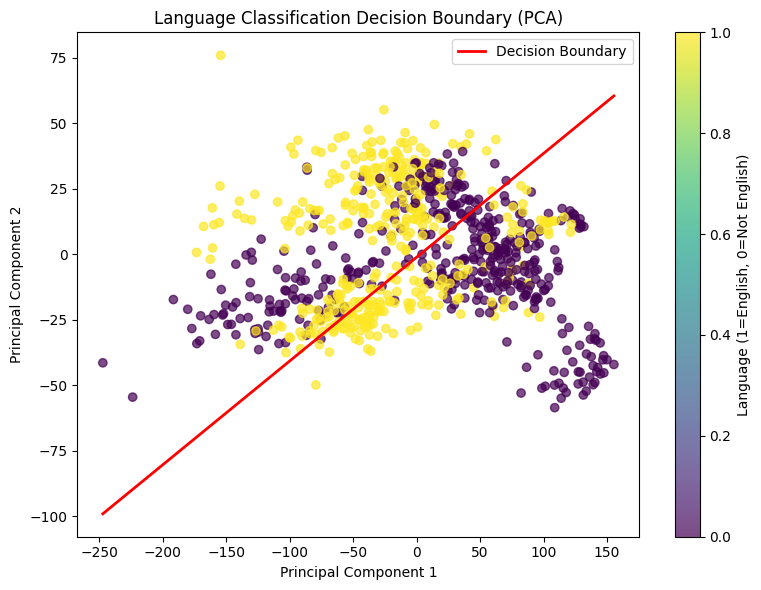

In [34]:
# For language labels:
learning_rate = 0.001
num_iterations = 10000
w, b = train_logistic_regression(X, y_language, learning_rate, num_iterations)

# 2. Get the predictions (0/1) for your training data
predictions = predict_logistic_regression(X, w, b, threshold=0.5)

# 3. Print classification metrics
print("\nClassification Report:")
print(classification_report(y_language, predictions))

plot_pca_decision_boundary(
    X, y_language, w, b, 
    n_components=2, comp_x=0, comp_y=1, 
    label_type="Language (1=English, 0=Not English)",
    title="Language Classification Decision Boundary (PCA)"
)

It's not classified well enough with two principal components as seen in the graph, but using all 13 components would help (or perhaps overfit if cross validation is not used).

# Mathematical Explanation 

## 1. Feature Extraction: MFCC Averaging

For each audio file, we extract Mel Frequency Cepstral Coefficients (MFCCs) which provide a compact representation of the audio's spectral properties.

- **MFCC Extraction:**  
  The audio signal is first transformed into the frequency domain using a Short-Time Fourier Transform (STFT). The resulting spectrogram is mapped to the Mel scale (a perceptually motivated frequency scale), and then a Discrete Cosine Transform (DCT) is applied to decorrelate the coefficients.

- **Averaging MFCCs:**  
  Let \( \text{MFCC}(i, t) \) be the \( i \)-th MFCC coefficient at time frame \( t \). The function computes the mean value of each coefficient across all \( T \) time frames:

  $$ 
  \text{MFCC}_\text{mean}(i) = \frac{1}{T} \sum_{t=1}^{T} \text{MFCC}(i, t)
  $$

  This averaged vector serves as a fixed-length feature representation of the audio file.

## 2. Dataset Construction and Labeling

The dataset is built by reading a metadata CSV file containing at least the columns: `filename`, `speaker_label`, and `language_label`. For each audio file:

- **Feature Vector (\( X \))**:  
  The averaged MFCC vector obtained from the audio file.

- **Binary Labels:**  
  Two binary labels are created:
  - **Speaker Label (\( y_{\text{speaker}} \))**:

    $$
    y_{\text{speaker}} = 
    \begin{cases}
    1, & \text{if the speaker is "Jeevan"} \\
    0, & \text{otherwise}
    \end{cases}
    $$

  - **Language Label (\( y_{\text{language}} \))**:

    $$
    y_{\text{language}} = 
    \begin{cases}
    1, & \text{if the language is "English"} \\
    0, & \text{otherwise}
    \end{cases}
    $$

## 3. K-Fold Cross Validation

K-Fold Cross Validation is used to assess the generalization performance of a model. The procedure is as follows:

- **Data Splitting:**  
  The dataset is split into \( K \) folds (e.g., 5). For each fold \( i \) (where \( i = 1, \dots, K \)):

  - **Train** the model on \( K-1 \) folds.
  - **Test** the model on the remaining fold.

- **Performance Metrics:**  
  Let \( a_i \) be the performance (e.g., accuracy) on the \( i \)-th fold. The overall performance is computed as:

  $$
  \text{Average Accuracy} = \frac{1}{K} \sum_{i=1}^{K} a_i
  $$

  and the standard deviation is:

  $$
  \sigma = \sqrt{\frac{1}{K} \sum_{i=1}^{K} \left(a_i - \text{Average Accuracy}\right)^2}
  $$

  This approach provides a robust performance estimate by averaging over multiple train-test splits.

## 4. Classification Models

In the extended code, we evaluate multiple classifiers using K-Fold Cross Validation. Here are the mathematical (and conceptual) foundations of these classifiers:

---

### 4.1 Support Vector Machine (SVM)

**Goal:** Find a hyperplane that maximizes the margin between two classes.  

1. **Linear SVM Decision Boundary:**

   $$
   w \cdot x + b = 0
   $$

   where \( w \) is the weight vector and \( b \) is a bias term.

2. **Hard-Margin Optimization (Linearly Separable Data):**  
   The SVM solves

   $$
   \min_{w, b} \;\; \frac{1}{2} \|w\|^2
   $$

   subject to

   $$
   y_i(w \cdot x_i + b) \ge 1 \quad \forall i,
   $$

   where \( y_i \in \{-1, +1\} \) are the class labels and \( x_i \) are feature vectors.

3. **Soft-Margin SVM (Realistic Case):**  
   Introduces slack variables \( \xi_i \) to allow some misclassifications:

   $$
   \min_{w, b, \xi} \;\; \frac{1}{2}\|w\|^2 + C \sum_{i=1}^N \xi_i
   $$

   subject to

   $$
   y_i(w \cdot x_i + b) \ge 1 - \xi_i, \quad \xi_i \ge 0.
   $$

---

### 4.2 Random Forest

**Goal:** Create an ensemble of diverse decision trees to reduce overfitting and improve predictive performance.

1. **Bootstrap Sampling:**  
   Each tree is trained on a **bootstrap sample** of the training data (sampling with replacement).

2. **Random Feature Subset:**  
   At each split in a tree, only a random subset of features is considered.

3. **Prediction Aggregation:**  
   The final prediction is made by majority vote across all trees:

   $$
   \hat{y} = \text{majority\_vote} \Bigl\{ T_1(x), T_2(x), \dots, T_m(x) \Bigr\},
   $$

   where \( T_j \) is the \( j \)-th decision tree, and \( m \) is the number of trees in the forest.

---

### 4.3 Logistic Regression

**Goal:** Model the probability that a given instance belongs to a certain class.

1. **Model Formulation:**  
   Logistic Regression assumes:

   $$
   \hat{y} = \sigma\bigl(w_0 + w_1 x_1 + \dots + w_n x_n\bigr)
   $$

   where the **sigmoid function** \( \sigma(z) \) is:

   $$
   \sigma(z) = \frac{1}{1 + e^{-z}}.
   $$

2. **Training Objective (Cross-Entropy Loss):**  
   We seek parameter values that minimize the log loss:

   $$
   \text{LogLoss} = -\sum_{i=1}^{N} \Bigl[y_i \log(\hat{y}_i) + (1 - y_i) \log\bigl(1 - \hat{y}_i\bigr)\Bigr],
   $$

   where \( y_i \in \{0,1\} \) is the true label and \( \hat{y}_i \) is the predicted probability.

---

## Summary

1. **MFCC Extraction:** Converts each audio file into a fixed-length feature vector by averaging MFCCs over time.  
2. **Dataset Construction:** Combines the MFCC feature vectors with binary labels (speaker, language) drawn from CSV metadata.  
3. **K-Fold Cross Validation:** Provides a robust estimate of model performance by averaging results across multiple train/test splits.  
4. **Classification Models:**
   - **SVM:** Finds a hyperplane (or decision boundary) that maximizes the margin.  
   - **Random Forest:** Constructs many decision trees from bootstrap samples and aggregates their predictions (majority vote).  
   - **Logistic Regression:** Models class probability via the sigmoid function and optimizes parameters by minimizing cross-entropy loss.


# Comparison of All models

## Recording and classifying a single audio

In [7]:
def predict_single_audio(model, file_path):
    # 1. Extract features
    features = extract_features(file_path)  # same function used in training
    # 2. Reshape (model expects a 2D array: [n_samples, n_features])
    features = features.reshape(1, -1)
    # 3. Predict
    y_pred = model.predict(features)
    return y_pred[0]


In [8]:
import tkinter as tk
import pyaudio
import wave

def record_audio(duration=3, filename='temp.wav'):
    chunk = 1024 
    format_ = pyaudio.paInt16
    channels = 1
    rate = 16000
    
    p = pyaudio.PyAudio()
    stream = p.open(format=format_, channels=channels, 
                    rate=rate, input=True, frames_per_buffer=chunk)
    
    frames = []
    for i in range(0, int(rate / chunk * duration)):
        data = stream.read(chunk)
        frames.append(data)
    
    stream.stop_stream()
    stream.close()
    p.terminate()
    
    wf = wave.open(filename, 'wb')
    wf.setnchannels(channels)
    wf.setsampwidth(p.get_sample_size(format_))
    wf.setframerate(rate)
    wf.writeframes(b''.join(frames))
    wf.close()

def classify_audio():
    # 1. record new audio
    record_audio(duration=3, filename='temp.wav')
    # 2. predict label
    label = predict_single_audio(my_trained_model, 'temp.wav')
    # 3. show in UI
    result_label.config(text=f"Predicted Label: {label}")

app = tk.Tk()
app.title("Audio Classifier")

record_button = tk.Button(app, text="Record & Classify", command=classify_audio)
record_button.pack()

result_label = tk.Label(app, text="Result will appear here")
result_label.pack()

app.mainloop()


: 